In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import localprojections as lp
import statsmodels.api as sm
from scipy.stats import norm

In [20]:
def show_irfs(horizon, irf_results, shock_vars, response_vars, bootstrap_draws: dict = None):
    if bootstrap_draws == None:
        horizons_arr = np.arange(horizon+1)
        n_shocks = len(shock_vars)
        fig, axes = plt.subplots(1, n_shocks, figsize=(5*n_shocks, 4), sharey=True)
        if n_shocks == 1:
            axes = [axes]
        for i, s in enumerate(shock_vars):
            ax = axes[i]
            irf_curve = irf_results[response_vars[0]][s]["irf"]
            lower_curve = irf_results[response_vars[0]][s]["lower"]
            upper_curve = irf_results[response_vars[0]][s]["upper"]
            ax.plot(horizons_arr, irf_curve, marker='o', label=f"IRF to {s} shock")
            ax.fill_between(horizons_arr, lower_curve, upper_curve, color='gray', alpha=0.3, label="95% CI")
            ax.axhline(0, color='black', linestyle='--', linewidth=1)
            ax.set_xlabel("Horizon")
            ax.set_title(f"Response of {response_vars[0]} to {s} shock")
            ax.legend()
            ax.grid(True)
        axes[0].set_ylabel("Impulse Response")
        plt.suptitle(f"IRFs of {response_vars[0]} to Shocks in All Variables")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
    else:
        horizons_arr = np.arange(horizon+1)
        n_shocks = len(shock_vars)
        fig, axes = plt.subplots(1, n_shocks, figsize=(5*n_shocks, 4), sharey=True)
        if n_shocks == 1:
            axes = [axes]
        for i, s in enumerate(shock_vars):
            ax = axes[i]
            irf_curve = irf_results[response_vars[0]][s]["irf"]
            lower_curve = irf_results[response_vars[0]][s]["lower"]
            upper_curve = irf_results[response_vars[0]][s]["upper"]
            # The bootstrap distribution, shape (B, horizon+1)
            draws = bootstrap_draws[response_vars[0]][s]
            # percentile intervals
            alpha = 0.05
            lower_q = 100*(alpha/2)
            upper_q = 100*(1-alpha/2)
            irf_lower_bs = np.percentile(draws, lower_q, axis=0)
            irf_upper_bs = np.percentile(draws, upper_q, axis=0)

            ax.plot(horizons_arr, irf_curve, marker='o', label=f"IRF to {s} shock")
            ax.fill_between(horizons_arr, lower_curve, upper_curve, color='gray', alpha=0.3, label="95% CI")
            ax.axhline(0, color='black', linestyle='--', linewidth=1)
            # bootstrap intervals in orange
            ax.plot(horizons_arr, irf_curve, linestyle=':', color='red', label='Bootstrap percentile CI')
            ax.fill_between(horizons_arr, irf_lower_bs, irf_upper_bs, color='red', alpha=0.2)
            ax.axhline(0, color='black', linestyle='--', linewidth=1)
            ax.set_xlabel("Horizon")
            ax.set_title(f"Response of {response_vars[0]} to {s} shock")
            ax.legend()
            ax.grid(True)
        axes[0].set_ylabel("Impulse Response")
        plt.suptitle(f"IRFs of {response_vars[0]} to Shocks in All Variables")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# What is a Local Projection?
Local Projections (LP), introduced by Jordà (2005), are an econometric method used to estimate the dynamic response of a variable (e.g., GDP, inflation) to a shock over multiple time horizons. 

For each forecast horizon $( h = 0, 1, \dots, H )$, LPs estimate a regression of the form:

$$
y_{t+h} = \alpha_h + \beta_h z_t + \gamma_h^\top X_t + \varepsilon_{t+h}
$$

where:
- $( y_{t+h})$: response variable at future horizon $( h ),$
- $( z_t)$: shock variable at time $( t )$,
- $( X_t)$: vector of control variables (lags, dummies, etc.),
- $( \beta_h )$: impulse response at horizon $( h )$.

LPs are attractive due to their simplicity and flexibility, especially compared to VARs.

The goal of this notebook is to replicate Figure 5 from Jordà (2005), which shows impulse response 
functions (IRFs) of three macroeconomic variables:
- Output Gap (GDP_gap),
- Inflation (Infl),
- Federal Funds Rate (FF),

in response to shocks in each of these variables using the LP method. We use quarterly U.S. data and estimate horizon-specific IRFs with two lags of all variables.

In [2]:
# Load the data
data = pd.read_csv("lplin_data.csv")
Y = ['GDP_gap', 'Infl', 'FF']  # endogenous variables

In [ ]:
def Local_Projections(
    data,
    Y,                # List of all system variables (e.g., ['GDP_gap','Infl','FF'])
    response,         # List of response variables for which IRFs are estimated
    horizon,          # Max forecast horizon (0..horizon)
    lags,             # Number of lags included for each variable
    newey_lags,       # Maxlags for Newey-West HAC SE
    ci_width,         # E.g. 0.95 for a 95% CI
    shock=None,       # If not None, only extract IRFs for these shock vars
    store_internals=False  # If True, also store design matrix, fitted, residuals for bootstrap
):
    """
    Estimates IRFs by local projections for each horizon h=0..H, each response in 'response',
    building a design matrix with 0..lags for each var in Y. Optionally stores 'internals'
    for each (r, h) so that we can do a bootstrap later without re-running the entire code.

    Returns
    -------
    results : dict
        results[resp][shock] = dict of arrays: 'irf', 'lower', 'upper' (length horizon+1)
    horizon_internals : dict (only if store_internals=True)
        horizon_internals[resp][h] = {
            'X_reg': DataFrame of regressors,
            'fitted': array of fitted values,
            'resid': array of residuals
        }
    """
    if shock is None:
        shock = Y.copy()

    # Prepare data structures for IRF results
    # Fill:
    results = {
        r: {s: {"irf": [], "lower": [], "upper": []} for s in shock}
        for r in response
    }

    # Optionally store internals if store_internals == True
    horizon_internals = {}
    if store_internals:
        horizon_internals = {
            r: {h: {} for h in range(horizon+1)}
            for r in response
        }

    # Loop over horizons and response variables

            # Dependent variable: y_{t+h}


            # Build the design matrix: for each var in Y, include lag0..lags

            # Add constant

            # Align, drop missing

            # OLS with NW

            # Save fitted & residual if needed
            if store_internals:
                horizon_internals[r][h]['X_reg'] = X_reg
                horizon_internals[r][h]['fitted'] = model.fittedvalues.values
                horizon_internals[r][h]['resid']  = model.resid.values

            # Extract IRFs for each shock variable

    # Convert to arrays

    # Return results. If store_internals, also return horizon_internals
    if store_internals:
        return results, horizon_internals
    else:
        return results, None

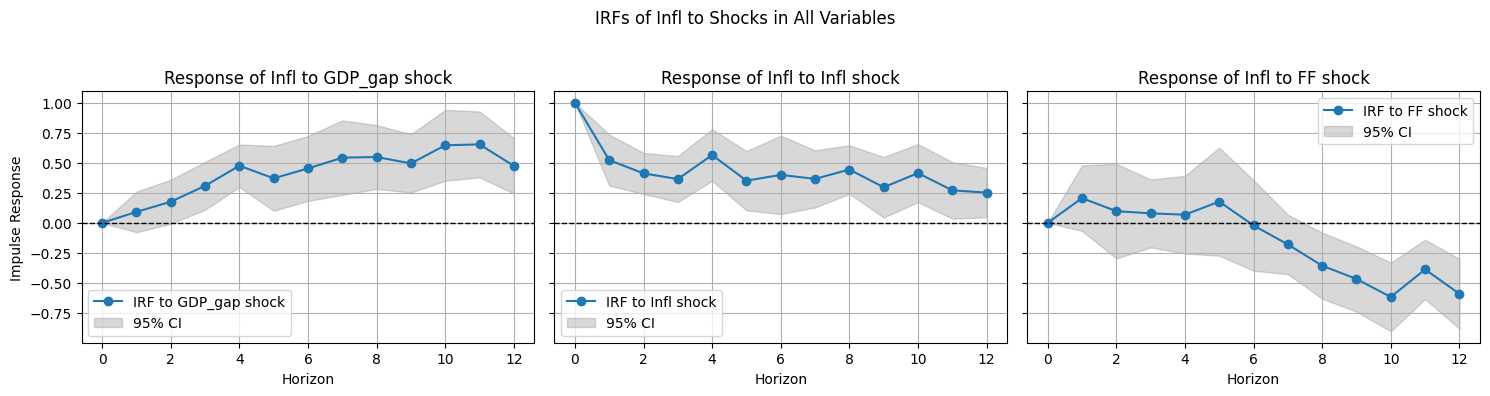

In [5]:
# Convert columns to list (if needed)
Y = list(data.columns)  # e.g. ['GDP_gap', 'Infl', 'FF']

# Here we want to estimate the IRFs for the response variable 'Infl'
# (i.e., how Inflation responds) to shocks from each variable in Y.
response_vars = ['Infl']
shock_vars = Y   # shocks from all variables in the system

# Set replication parameters:
horizon = 12      # forecast horizon: 0,1,...,12
lags = 4          # number of lags to include for each variable
newey_lags = 4    # HAC lags for Newey-West standard errors
ci_width = 0.95   # 95% confidence interval

# Estimate IRFs using our custom function (Step 1)
irf_results, _ = Local_Projections(data=data, 
                                    Y=Y, 
                                    response=response_vars, 
                                    horizon=horizon, 
                                    lags=lags, 
                                    newey_lags=newey_lags, 
                                    ci_width=ci_width, 
                                    shock=shock_vars)

show_irfs(horizon, irf_results, shock_vars, response_vars, )

In [ ]:
def bootstrap_LP(data, Y, response, horizon, lags, newey_lags,ci_width=0.95, shock=None, B=500, seed=None):
    """
    1) Call Local_Projections(..., store_internals=True) to get original IRFs + design/resid
    2) For each horizon h and response var r, do the residual bootstrap
    3) Return (original_coefs, boot_draws)
    """

    if seed is not None:
        np.random.seed(seed)

    # Step 1: get original IRFs plus the internals

    # 'lp_results' is the same dictionary of IRFs, lower, upper from NW
    # 'horizon_internals' contains X_reg, fitted, resid for each horizon

    # Let's build a structure for the boot_coefs: boot_coefs[r][s] = (B, horizon+1)
    if shock is None:
        shock = Y
    boot_coefs = {
        r: {s: np.zeros((B, horizon+1)) for s in shock}
        for r in response
    }

    # Step 2: For each replication b, horizon h, response r:

    return lp_results, boot_coefs

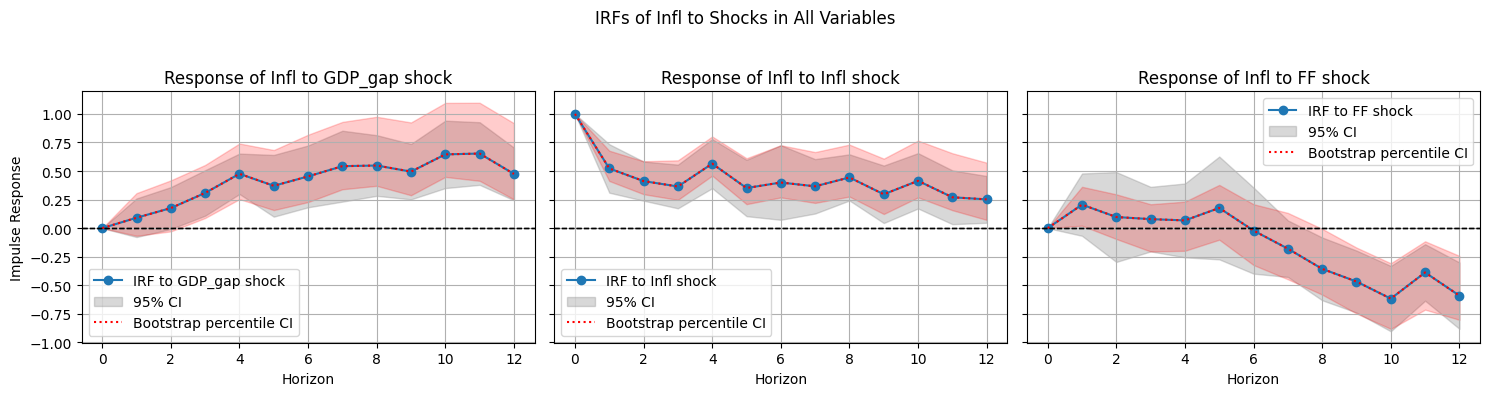

In [19]:
# number of bootstrap replications
B = 500

# 1) get NW-based IRFs + do store_internals
lp_results, boot_draws = bootstrap_LP(data, Y, response_vars, horizon, lags, newey_lags, ci_width=ci_width, shock=shock_vars, B=B, seed=123)

show_irfs(horizon, irf_results, shock_vars, response_vars, boot_draws)